In [2]:
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Deep\ Learning\ Project/multi-modal-music-genre-classification/
%ls

/content/drive/.shortcut-targets-by-id/171ooq7ooYWU0qxPszBUOL0gPzYTH3uuB/Deep Learning Project/multi-modal-music-genre-classification
4mula.ipynb                           4mula_small.parquet
4MULa_melspectrogram_part_1.parquet   Audio_dataprep.ipynb
4MULa_melspectrogram_part_2.parquet   lyrics.txt
4MULa_melspectrogram_part_56.parquet  Melspectrogram@
4mula_metadata.parquet


In [5]:
import pandas as pd
import numpy as np
import os, glob
import pyarrow.parquet as pq

In [6]:
NUM_GENRES = 10
DATASET_SIZE = 2000
LANGUAGE = 'en'

In [7]:
import tqdm
music_id_to_part = []
for filename in tqdm.tqdm(glob.glob("./Melspectrogram/4MULa_melspectrogram_part_*.parquet")):
    part = os.path.splitext(filename)[0].split("_")[-1]
    df = pd.read_parquet(filename, columns=['music_id'])
    df['part'] = part
    music_id_to_part.append(df)
music_id_to_part = pd.concat(music_id_to_part)
music_id_to_part.drop_duplicates(['music_id'], inplace=True)

100%|██████████| 91/91 [00:02<00:00, 43.48it/s]


In [8]:
metadata = pd.read_parquet("./4mula_metadata.parquet")
metadata.drop_duplicates(subset=['music_id'], inplace=True)
metadata.head()

,music_id,music_name,music_lang,music_lyrics,art_id,art_name,art_rank,main_genre,related_genre,related_art,related_music
0,3ade68b8g0b5ca0b3,Artemísia,pt-br,Não vai nascer\nPorque eu não quero\nPorque eu...,3ade68b7g5cb92ea3,Carne Doce,8399,Indie,"['Indie', 'Folk', 'MPB']",[],[]
1,3ade68b8g7668fea3,Chapadão,pt-br,Chapadão já alquebrado\nCofre de recordação\nD...,3ade68b7gfa400ea3,Goiá,9944,Sertanejo,['Sertanejo'],"[{'id': '3ade68b7g29961ea3', 'name': 'Biá e Go...",[]
2,3ade68b8g9d86ffa3,Cuckoo,en,Feels like I'm having a meltdown\nIt feels lik...,3ade68b7g48731ea3,Adam Lambert,985,Pop,"['Pop', 'Pop/Rock', 'Romântico', 'Rock', 'Danc...","[{'id': '3ade68b5g2677eda3', 'name': 'Pink'}, ...","[{'id': '3ade68b8g2649ffa3', 'name': 'As Mina ..."
3,3ade68b7g1589cea3,El Lobo,es,(Feat. Hector The Father) \n\nAWOOOOOOOO!!! \n...,3ade68b6g9601fda3,Alexis Y Fido,8187,Reggaeton,"['Reggaeton', 'Hip Hop', 'Electronica', 'Rap',...","[{'id': '3ade68b6g7796fda3', 'name': 'Angel Y ...",[]
4,3ade68b8geb5dd0b3,Meu Coração é o Teu Altar,pt-br,Que um altar dentro de mim seja erguido\nQue m...,3ade68b6g759eeda3,Eliane Silva,842,Gospel/Religious,"['Gospel/Religioso', 'Instrumental', 'Infantil...","[{'id': '3ade68b6g7c9cfda3', 'name': 'Amanda F...",[]


### Remove entries in metadata but not in data

In [14]:
metadata = pd.merge(music_id_to_part, metadata, how="left", on=["music_id"])

### Observe genres in the dataset

In [15]:
genres = pd.unique(metadata.main_genre)
print(f"There are {len(genres)} unique genres: {genres}")

eng_metadata = metadata[metadata['music_lang']==LANGUAGE]
print(eng_metadata['main_genre'].value_counts()[0:15].to_string())

There are 77 unique genres: ['Pagode' 'Forró' 'Rock' 'MPB' 'Emocore' 'Unknown' 'Pop/Rock' 'Dance'
 'Country' 'Rap' 'K-Pop/K-Rock' 'Gospel/Religious' 'Gothic' 'Sertanejo'
 'Hip Hop' 'Punk Rock' 'Samba Enredo' 'Folk' 'Romantic' 'R&B' 'Soundtrack'
 'Chillout' 'Samba' 'Alternative Rock' 'Fado' 'Axé' 'Pop' 'Indie'
 'World Music' 'Tecnopop' 'Hard Rock' 'Reggae' 'Progressive' 'Black Music'
 'Rockabilly' 'Electronic' 'Kids' 'Regional' 'Funk Carioca' 'Heavy Metal'
 'Funk' 'Velha Guarda' 'Disco' 'Soul Music' 'Blues' 'Hardcore'
 'Classic Rock' 'Soft Rock' 'Bossa Nova' 'Classic' 'Surf Music'
 'Reggaeton' 'Pop/Punk' 'Instrumental' 'Jazz' 'New Age' 'Post-Punk'
 'Grunge' 'Kizomba' 'J-Pop/J-Rock' 'Trance' 'New Wave' 'Jovem Guarda'
 'Trip-Hop' 'Power-Pop' 'House' 'Psicodelic' 'Músicas Gaúchas' 'Ska'
 'Piano Rock' 'Industrial' 'Tropical House' nan 'Metal' 'Post-Rock' 'Trap'
 'Electro Swing']
Rock                3536
Pop                 3043
Indie               2775
Unknown             2312
Heavy Metal  

### Select 10 of the most popular genres

In [16]:
selected_genres = ['Indie', 'Pop', 'Gospel/Religious', 'Rock', 'Romantic', 'Electronic', 'Rap', 'Hip Hop', 'R&B', 'Heavy Metal']
assert len(selected_genres)==NUM_GENRES
selected_cols = ['music_id', 'music_name', 'music_lang', 'music_lyrics', 'art_name', 'main_genre']
selected_metadata = eng_metadata[eng_metadata['main_genre'].isin(selected_genres)][selected_cols].reset_index()
selected_metadata

,index,music_id,music_name,music_lang,music_lyrics,art_name,main_genre
0,18,3ade68b7gc9a5dea3,Like A Boy,en,C-I-A-R-A\n\nPull up your pants\n(Just Like Em...,Ciara,Hip Hop
1,25,3ade68b8g895cd0b3,DOA,en,On our knees we pray\nAs we waste away\nAnd we...,I Prevail,Rock
2,27,3ade68b6g21f8fda3,I'm Coming Out,en,I'm coming out \nI'm coming \nI'm coming out \...,Amerie,R&B
3,35,3ade68b8g895fdfa3,Everything You Do,en,Do do do do do do do do do\nDo do do do do do ...,He Is We,Romantic
4,55,3ade68b8gac420fa3,Lost In Your Eyes,en,"I guess it's hard for me to say,\n\nWhy my hea...",3 Deep,Hip Hop
...,...,...,...,...,...,...,...
17907,84481,3ade68b8gd5c6a0b3,Muddy Waters,en,Muddy waters\nWe are kneeling at the rivers ed...,LP,Indie
17908,84491,3ade68b8gce84d0b3,Circles,en,And wake up to make up what is real\nRotate yo...,P.O.D.,Rock
17909,84493,3ade68b8g8f09dfa3,Carry On Wayward Son,en,Carry on my wayward son\nThere'll be peace whe...,Stryper,Gospel/Religious
17910,84499,3ade68b8gb4d580b3,She'll Move,en,First time you let go\nYou have no choice\nI k...,Lucy Rose,Indie


### Sample equally from each genre

In [17]:
final_metadata = selected_metadata.groupby('main_genre', group_keys=False).apply(lambda x: x.sample(DATASET_SIZE//NUM_GENRES))
# final_metadata = selected_metadata.sample(DATASET_SIZE).reset_index(drop=True).sort_values(by='index')
final_metadata

,index,music_id,music_name,music_lang,music_lyrics,art_name,main_genre
15011,71869,3ade68b8gc7d3b0b3,Shed a Light (Ft. David Guetta & Cheat Codes),en,Why are you keeping me at a distance?\nAll tha...,Robin Schulz,Electronic
2541,12553,3ade68b8g428b20b3,Again And Again (Part. Dominic Balli),en,I suddenly found myself drifting far from the ...,DJ PV,Electronic
9320,46657,3ade68b8g12c7c0b3,"These Days (Feat. Jess Glynne, Macklemore & Da...",en,I know you moved onto someone new\nHope life i...,Rudimental,Electronic
11474,56354,3ade68b8gbb52a0b3,True Colors (feat. Kesha),en,Stars fall at my feet\nKeep me grounded as I r...,Zedd,Electronic
1919,9526,3ade68b8gd62db0b3,Another Life (With David Guetta feat. Ester Dean),en,"I'm waking up, thinking how we used to be\nI s...",Afrojack,Electronic
...,...,...,...,...,...,...,...
13601,65683,3ade68b5g7e08eda3,How Could An Angel Break My Heart,en,I heard he sang a lullaby\nI heard he sang it ...,Toni Braxton,Romantic
5769,29038,3ade68b7gf0b84ea3,Let Me Go,en,One more kiss could be the best thing\none mor...,3 Doors Down,Romantic
13952,67228,3ade68b7g0f199ea3,A Little Bit Of Love,en,I believe If you give a little bit of love to ...,Paul Young,Romantic
4216,21339,3ade68b8gdc368fa3,Tonight,en,"Tonight, Tonight, won't be just any night.\nTo...",Johnny Mathis,Romantic


### Get melspectrograms from full data

In [18]:
set(music_id_to_part['music_id']).intersection(set(final_metadata['music_id'])) == set(final_metadata['music_id'])

True

In [19]:
final_metadata = pd.merge(music_id_to_part, final_metadata, how="inner", on=['music_id'])

In [20]:
final_metadata.head()

,music_id,part,index,music_name,music_lang,music_lyrics,art_name,main_genre
0,3ade68b8gf9bceea3,2,74,Back To Black,en,He left no time to regret\nKept his dick wet\n...,Amy Winehouse,R&B
1,3ade68b7g41a96ea3,2,85,Jellicle Songs For Jellicle Cats,en,Are you blind when you're born? Can you see in...,Cats (Musical),Pop
2,3ade68b8g1cdaafa3,2,97,All Night Long,en,I see everybody around\nBut it feels like we'r...,Alexandra Burke,Pop
3,3ade68b8g0fb0d0b3,2,98,Idwk,en,Every morning you wake up\nAnd you're reaching...,Dvbbs,Electronic
4,3ade68b8ga515d0b3,2,102,Trust My Lonely,en,It's time I let you go\nI made the mistake\nOf...,Alessia Cara,Indie


In [26]:
spectrograms = []
for k, g in tqdm.tqdm(final_metadata.groupby('part')):
    filename = f"./Melspectrogram/4MULa_melspectrogram_part_{k}.parquet"
    df = pq.ParquetDataset(filename, use_legacy_dataset=False, filters=[('music_id','in',g.music_id)])
    spectrograms.append(df.read(columns = ['music_id', 'melspectrogram']).to_pandas())
spectrograms = pd.concat(spectrograms)
spectrograms

100%|██████████| 91/91 [24:02<00:00, 15.85s/it]


,music_id,melspectrogram
0,3ade68b8g6d8850b3,"[[4.85775805, 3.82197762, 4.6521306, 8.6838884..."
1,3ade68b7g6eb33ea3,"[[0.27425459, 0.0835421607, 0.0117106298, 0.04..."
2,3ade68b8ge73a60b3,"[[0.332293779, 0.354809701, 0.248878196, 0.031..."
3,3ade68b8g90ff6fa3,"[[12.4767904, 23.5574665, 52.1779213, 54.11869..."
4,3ade68b7g8cc65ea3,"[[0.0413891375, 0.0546203144, 0.0574561432, 0...."
...,...,...
6,3ade68b8ga3acd0b3,"[[0.972605824, 0.310011208, 0.1938418, 0.22529..."
7,3ade68b7gb5e73ea3,"[[29.5681152, 8.50790405, 1.10087693, 1.239189..."
8,3ade68b7g63c94ea3,"[[0.00198460114, 0.00115074578, 0.000372220384..."
9,3ade68b8g8f09dfa3,"[[24.1071796, 5.92469883, 0.0383412205, 0.0804..."


In [30]:
print(spectrograms['music_id'].value_counts())
spectrograms.drop_duplicates(subset=['music_id'], inplace=True)

3ade68b8g3326a0b3    3
3ade68b8g6d8850b3    1
3ade68b8gc05cc0b3    1
3ade68b8g5aaed0b3    1
3ade68b7g51bc8ea3    1
                    ..
3ade68b8g317640b3    1
3ade68b8g419ec0b3    1
3ade68b8g3dd7bfa3    1
3ade68b8g02d9c0b3    1
3ade68b6g835deda3    1
Name: music_id, Length: 2000, dtype: int64


In [55]:
spectrograms.to_csv('spectrograms.csv')

### Final data

In [32]:
data = pd.merge(spectrograms, final_metadata, how = "inner", on = ["music_id"])
data

,music_id,melspectrogram,part,index,music_name,music_lang,music_lyrics,art_name,main_genre
0,3ade68b8g6d8850b3,"[[4.85775805, 3.82197762, 4.6521306, 8.6838884...",1,1005,Pacifier,en,There's always something to hide\nThere's alwa...,Catfish And The Bottlemen,Indie
1,3ade68b7g6eb33ea3,"[[0.27425459, 0.0835421607, 0.0117106298, 0.04...",1,1042,Daughters,en,I know a girl\nShe puts the color inside of my...,John Mayer,Romantic
2,3ade68b8ge73a60b3,"[[0.332293779, 0.354809701, 0.248878196, 0.031...",1,1051,Groove,en,"Let's get it\nWe groovy baby\nGroove!\n\nSo, t...",Jack and Jack,Rap
3,3ade68b8g90ff6fa3,"[[12.4767904, 23.5574665, 52.1779213, 54.11869...",1,1094,All Things Are Possible,en,"Almighty God, my redeemer \nMy hiding place, m...",Darlene Zschech,Gospel/Religious
4,3ade68b7g8cc65ea3,"[[0.0413891375, 0.0546203144, 0.0574561432, 0....",1,1142,Song For A Friend,en,Well you're magic he said\nBut don't let it al...,Jason Mraz,Romantic
...,...,...,...,...,...,...,...,...,...
1995,3ade68b8ga3acd0b3,"[[0.972605824, 0.310011208, 0.1938418, 0.22529...",91,84322,Soft To Be Strong,en,I know it's hard to be soft\nI know it hurts t...,Marina And The Diamonds,Pop
1996,3ade68b7gb5e73ea3,"[[29.5681152, 8.50790405, 1.10087693, 1.239189...",91,84430,Can't Get Up,en,Written by Supergrass\n\nWaking up on a Sunday...,Supergrass,Indie
1997,3ade68b7g63c94ea3,"[[0.00198460114, 0.00115074578, 0.000372220384...",91,84479,I Wish,en,"I wish to give, to take, to make, to shake\nI ...",Skazi,Electronic
1998,3ade68b8g8f09dfa3,"[[24.1071796, 5.92469883, 0.0383412205, 0.0804...",91,84493,Carry On Wayward Son,en,Carry on my wayward son\nThere'll be peace whe...,Stryper,Gospel/Religious


In [33]:
data['main_genre'].value_counts()

Indie               200
Romantic            200
Rap                 200
Gospel/Religious    200
Hip Hop             200
R&B                 200
Pop                 200
Heavy Metal         200
Electronic          200
Rock                200
Name: main_genre, dtype: int64

In [56]:
data['music_id'].value_counts()

3ade68b8g6d8850b3    1
3ade68b8g09c2e0b3    1
3ade68b8g088ed0b3    1
3ade68b8gc05cc0b3    1
3ade68b8g5aaed0b3    1
                    ..
3ade68b8g317640b3    1
3ade68b8g419ec0b3    1
3ade68b8g3dd7bfa3    1
3ade68b8g02d9c0b3    1
3ade68b6g835deda3    1
Name: music_id, Length: 2000, dtype: int64

In [57]:
data.to_csv("final_data_2k.csv")

### Visualizing a spectrogram

In [51]:
import matplotlib.pyplot as plt
import librosa, librosa.display

In [52]:
mel_sample = data.sample()
mel_sample = np.vstack(mel_sample['melspectrogram'].values[0])
mel_sample.shape

(128, 1292)

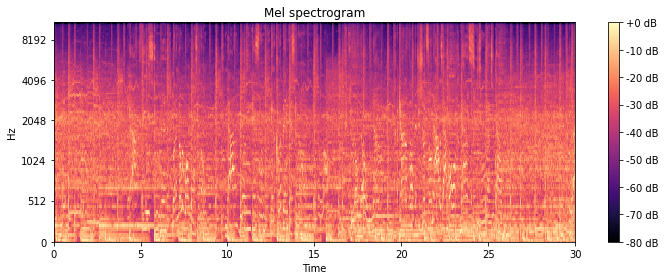

In [53]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_sample, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [58]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   4mula.ipynb
	modified:   Audio_dataprep.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	4MULa_melspectrogram_part_1.parquet
	4MULa_melspectrogram_part_2.parquet
	4MULa_melspectrogram_part_56.parquet
	4mula_metadata.parquet
	4mula_small.parquet
	Melspectrogram
	final_data_2k.csv
	lyrics.txt
	spectrograms.csv

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git config --global user.email "kritika29498@gmail.com"
!git config --global user.name "kritika-gupta"

In [ ]:
!git add 4mula.ipynb
!git commit -m "Exploring 4mula"
!git push origin main

[main daff5a9] Exploring 4mula
 1 file changed, 1 insertion(+)
 create mode 100644 4mula.ipynb
Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 174.70 KiB | 7.94 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/kritika-gupta/multi-modal-music-genre-classification
   7b23825..daff5a9  main -> main
